# GOES autoregression modeling

[Autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model) are one of the most common forms of time series model.  The most familiar autoregressive (AR) model is a linear autoregressive model, but there are many forms of non-linear autoregressive model and this area remains highly active in terms of research.

Here we use linear autoregressive models to assess the information in past flux measurements for predicting the current flux measurement.  We incorporate a gap between the past measurements, 'x' and the present measurement 'y'. This analysis provides insight into how the information in the past about the present is best summarized and represented.

Since linear AR models naturally exhibit multicollinearity (due to autocorrelation), we use [ridge regression](https://en.wikipedia.org/wiki/Ridge_regression) here to fit the models.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats.distributions import chi2
from read import *

We will use ridge regression to fit our autoregression models.

In [65]:
def ridge(x, y, f):
    """Regress y on x using ridge regression, with penalty parameter f."""
    u, s, vt = np.linalg.svd(x, 0)
    v = vt.T
    g = s / (s**2 + f)
    b = np.dot(v, np.dot(u.T, y) * g)
    return b

Parameter tuning is an important practical issue for most modern forms of statistical modeling.  The question of how to tune ridge regression has been extensively considered, but remains challenging.  A fairly [recent paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4790465/) proposes a new way to train ridge regression and evaluates the tuning method quite extensively.

In [66]:
# Ridge regression with tuning based on a hyperpenaized log likelihood.
# Requires a guess of the R^2 (r2).
def tuneridge(x, y, r2):

    n, p = x.shape

    # The hyperpenalty parameters
    a = p / 2
    b = 1 / np.sqrt(1/r2 - 1)

    # Estimate the parameters for fixed penalty value using ridge regression.
    u, s, vt = np.linalg.svd(x, 0)
    v = vt.T
    def fit(lam):
        g = s / (s**2 + lam)
        return np.dot(v, np.dot(u.T, y) * g)

    lam = 1.
    bhat = fit(lam)
    for itr in range(100):
        resid = y - np.dot(x, bhat)
        rss = np.sum(resid**2)
        bss = np.sum(bhat**2)
        
        # Equation 21
        sigma2 = (rss + lam*bss) / (n + p + 2)
        
        # Equation 24
        lam = (p + 2*a - 2) / (bss/sigma2 + 2*b)
        
        bhat1 = fit(lam)
        if np.sum((bhat1 - bhat)**2) < 1e-4:
            break
        bhat = bhat1

    return bhat, lam, sigma2

Below we use a very limited simulation study to assess the performance of the tuning procedure.

In [67]:
def test_tuneridge1(n, p, r, sig):
    x = np.random.normal(size=(n, p))
    for j in range(1, p):
        x[:, j] = r*x[:, j-1] + np.sqrt(1-r**2)*x[:, j]
    b = np.zeros(p)
    b[0] = 1
    b[1] = -1
    Ey = np.dot(x, b)
    y = Ey + sig*np.random.normal(size=n)

    r2 = np.var(Ey) / (np.var(Ey) + sig**2)
    ii = np.arange(p)
    covx = r**np.abs(np.subtract.outer(ii, ii))

    # The large sample optimal lambda (section 4.1)
    lam_opt = sig**2 * np.trace(np.linalg.inv(covx)) / np.dot(b, np.linalg.solve(covx, b))

    bhat, lam, sigma2 = tuneridge(x, y, r2)
    return lam, lam_opt, r2, bhat

def test_tuneridge(n, p, r, sig, nrep=100):
    lam, lam_opt, r2, bhat = [], [], [], []
    for k in range(nrep):
        lam1, lam_opt1, r21, bhat1 = test_tuneridge1(n, p, r, sig)
        lam.append(lam1)
        lam_opt.append(lam_opt1)
        r2.append(r21)
        bhat.append(bhat1)
    return np.asarray(lam), np.asarray(lam_opt), np.asarray(r2), np.asarray(bhat)

In [68]:
n = 200
p = 5
r = 0.5
sig = 2
lam, lam_opt, r2, bhat = test_tuneridge(n, p, r, sig)
print("Expected parameter estimate:\n", bhat.mean(0))
print("Standard error of parameter estimate:\n", bhat.std(0))
print("lambda:\n", lam.mean(), " ", lam.std())
print("optimal lambda:\n", lam_opt.mean(), " ", lam_opt.std())

Expected parameter estimate:
 [ 0.98788891 -0.92688987 -0.00651564 -0.04120808 -0.01060697]
Standard error of parameter estimate:
 [0.1700609  0.20953368 0.19433672 0.18550445 0.16935032]
lambda:
 5.38119345979022   0.6644653380217824
optimal lambda:
 7.076923076923079   2.6645352591003757e-15


Now we proced to use linear autoregression, to assess the conditional dependence structure of the flux series in the GOES study.

In [69]:
df = get_goes(2017)

Use blocks of size m, and use the first q observations within each block to predict the final observation in the block.

In [70]:
m = 1000
q = 200

print("Gap between final x and y: ", )

Gap between final x and y: 


The time points of the predictor information relative to the time being predicted.

In [71]:
tax = np.arange(-2*m, -2*(m-q))[0:q] / 60

Make blocks of 'm' consecutive time points with approximately 2-second spacing.

In [72]:
tix, flx = make_blocks(df, m, 0)

In [73]:
flx = np.log(1e-8 + flx)

Create a design matrix and response vector

In [74]:
x = flx[:, 0:q]
y = flx[:, -1]

Center the data.  This is very common in ridge regression and allows us to do the analysis without including an intercept term.

In [75]:
y -= y.mean()
x -= x.mean(0)

In [76]:
xtx = np.dot(x.T, x)

In [80]:
# Consider how the regression coefficients look for various values
# of the penalty parameter, as specified through the value of r^2.
def fit(x, y, randomize):

    if randomize:
        ii = np.random.permutation(len(y))
        y = y[ii]

    for r2 in [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]:
        b, lam, s2 = tuneridge(x, y, r2)

        H = xtx + lam*np.eye(q)
        V = s2 * np.linalg.solve(H, np.linalg.solve(H, xtx).T)
        cs = np.dot(b, np.linalg.solve(V, b))
        pv = 1 - chi2(len(b)).cdf(cs)

        plt.clf()
        plt.grid(True)
        plt.plot(tax, b, "-")
        plt.ylabel("Coefficient", size=15)
        plt.xlabel("Minutes before current time", size=15)
        plt.title("r2=%.2f, lambda=%.1f" % (r2, lam))
        plt.show()

First we fit the models to the actual GOES flux data, using a series of $r^2$ values.

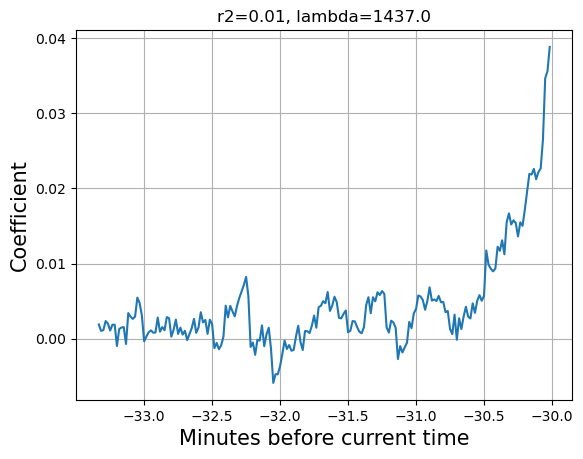

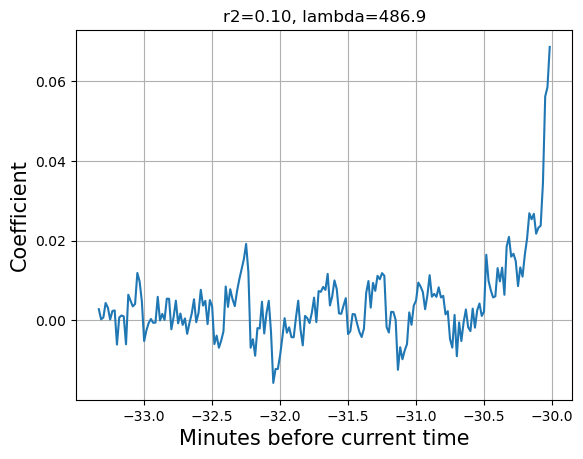

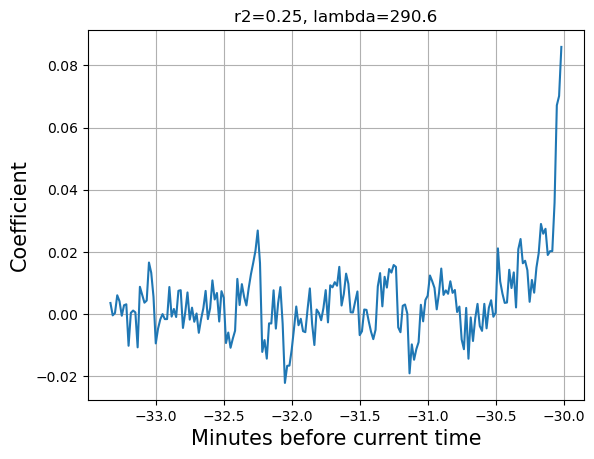

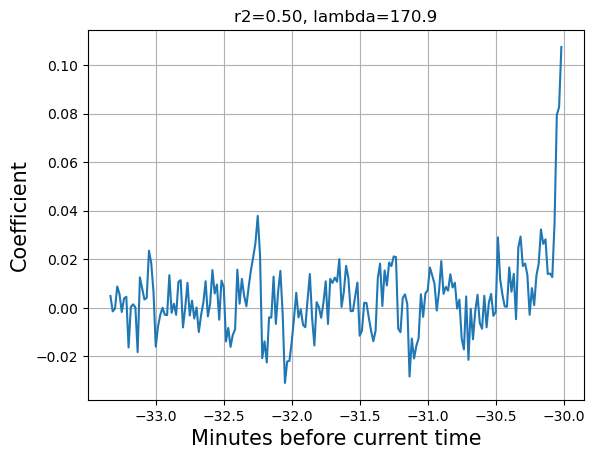

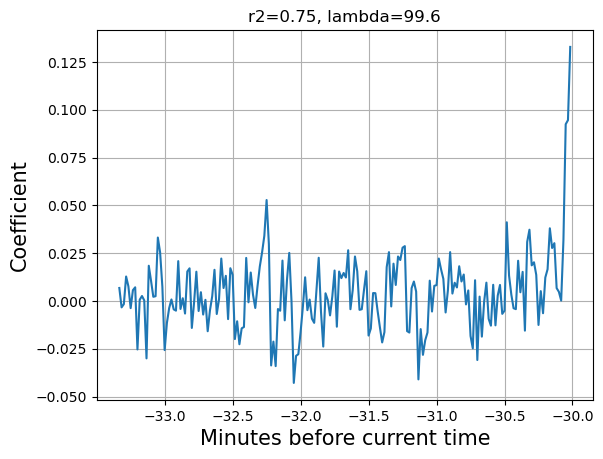

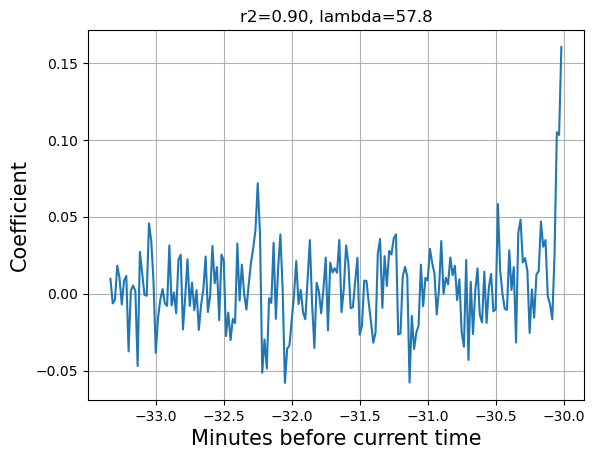

In [78]:
fit(x, y, False)

Now we fit the models to data in which the response values $y$ have been randomized.  These allow us to assess the level of estimation noise in the parameter estimates.  Potentially the values below could be used to identify a level beyond which parameter estimates would be deemed to be statistically significant.

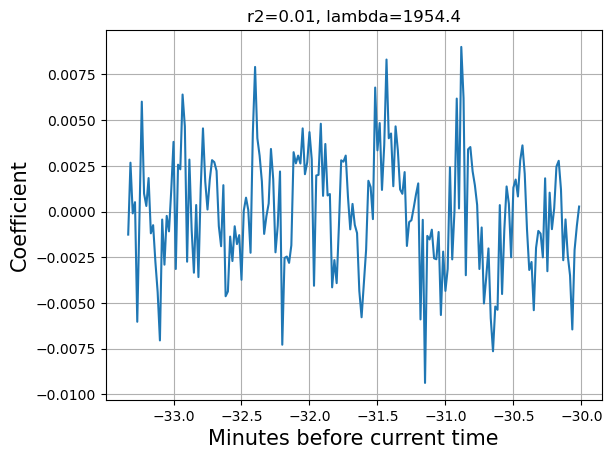

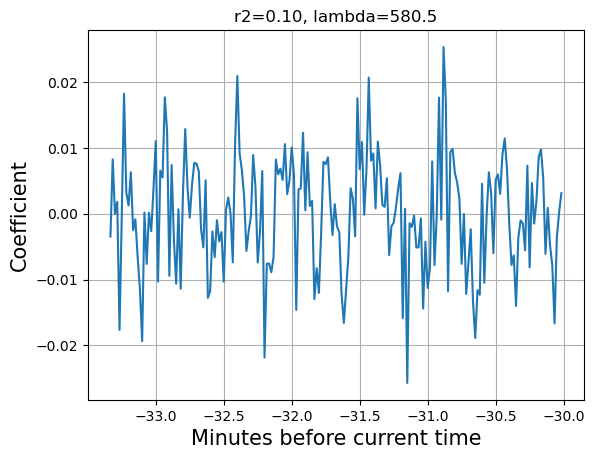

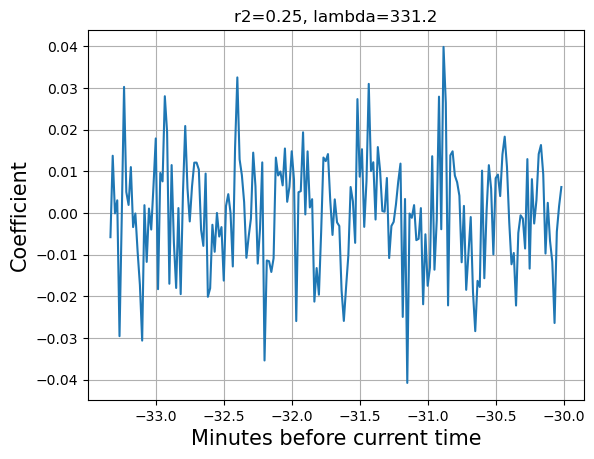

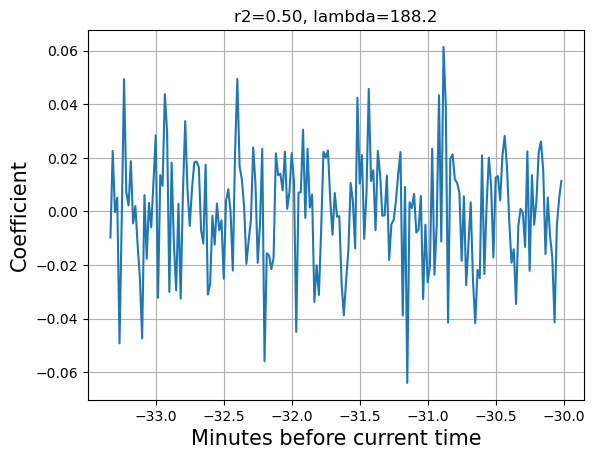

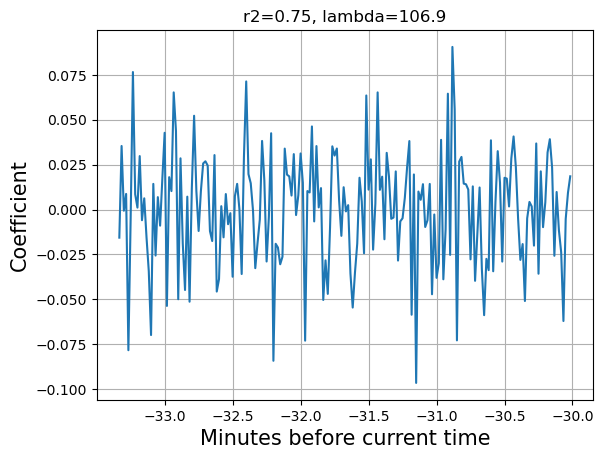

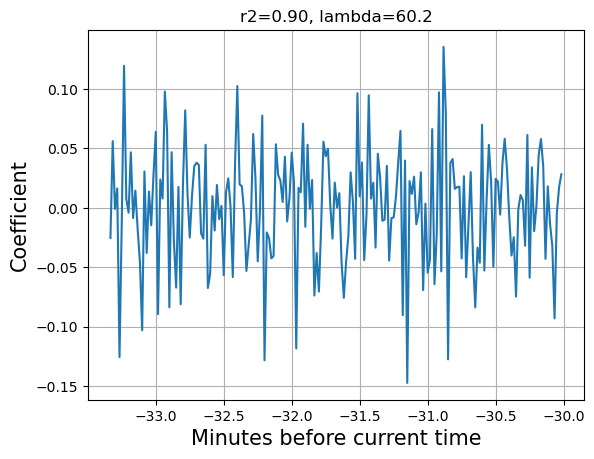

In [79]:
fit(x, y, True)